# Teoria Moderna do Portfólio
O MPT ( Modern Portfolio Theory ) ou Teoria Moderna do Portfólio é um modelo teórico de otimização de ativos numa carteira. Basicamente temos o trabalho de Harry Max Markowitz (1952) a respeito de retornos em relação a maior risco tomado, a importância de diversificação e dois tipos de riscos atrelados a gestão de uma carteira – riscos sistêmicos, como juros, recessões, crises,etc atrelados ao mercado ( que podemos estimar na medida do Beta ) – e risco não sistêmico, individualizados ao setor, ao ativo, como uma administração ruim, um momento de vendas ruim, ( sendo essa medida relacionada ao Alfa).

## Ideia geral: maximizar o Índice de Sharpe
o Índice de Sharpe (SHARPE,1966) é uma medida de retorno ajustado ao risco.Esse índice será a referência para que tomemos os pesos dos ativos presentes na carteira, na proporção que propicie o maior índice de Sharpe. Basicamente serão simulados 10000 carteiras com pesos randomizados, usando dados de preços e retornos de 01/12/2019 até 01/12/2020, sendo salvo a alocação onde há menor volatilidade ( apenas para demonstração no gráfico ) e a com o maior Índice de Sharpe.

# AVISO: Isso não é uma recomendação de investimento e nem de compra/venda de ativos.
## E vamos ao script…

In [2]:
#Carregando as blibliotecas necessárias
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as sm

In [3]:
livre_de_risco = 0.02 #Basicamente a taxa básica de juros
criptos = ['ETH-USD', 'XRP-USD', 'LTC-USD', 'XMR-USD', 'DASH-USD'] #A escolha da carteira é arbitrária, mas o ideal é pensar na liquidez ( moedas mais negociadas )
data_inicio ='1/01/2017' #Padrão americano MM/DD/AAAA, o período vai de Dezembro de 2019 a Dezembro de 2020 
data_final ='4/01/2021'
dados = web.DataReader(criptos,data_source='yahoo', start=data_inicio, end = data_final )['Adj Close']
dados.sort_index(inplace=True)
retornos = dados.pct_change()
retornos_medios = retornos.mean()
cov_matrix = retornos.cov()
np.random.seed(42)
num_portfolios = 10000 #Se preferir, dá pra ter simulações maiores, com 100 mil, 1 milhão de carteiras diferentes. Mas lembre-se que isso pode demorar muito mais sem resultados significantes em melhoria.
resultados = np.zeros((len(criptos)+3,num_portfolios))
for i in range(num_portfolios):
    pesos = np.array(np.random.random(5))
    pesos /= np.sum(pesos)
    #Como criptomoedas não possuem pregão, isto é, são 24/7, não se precisa descontar os finais de semana como em simulações de ações, por isso o 365
    retorno_portfolio = np.sum(retornos_medios * pesos)*365
    desvio_padrao_portfolio = np.sqrt(np.dot(pesos.T,np.dot(cov_matrix, pesos)))*np.sqrt(365)
    
    resultados[0,i] = retorno_portfolio 
    resultados[1,i] = desvio_padrao_portfolio
    resultados[2,i] = (resultados[0,i] / resultados[1,i]) - livre_de_risco # Índice de Sharpe 
    for j in range(len(pesos)):
        resultados[j+3,i] = pesos[j]
resultados_frame = pd.DataFrame(resultados.T,columns=['retorno','desvio_padrao','sharpe',criptos[0],criptos[1],criptos[2],criptos[3],criptos[4]])
retorno = resultados_frame.iloc[resultados_frame['retorno'].idxmax()]
max_sharpe_port = resultados_frame.iloc[resultados_frame['sharpe'].idxmax()]
min_vol_port = resultados_frame.iloc[resultados_frame['desvio_padrao'].idxmin()]
preços = pd.DataFrame()
for t in criptos:
    preços[t]=web.DataReader(t, data_source='yahoo', start = data_inicio, end = data_final)['Adj Close']

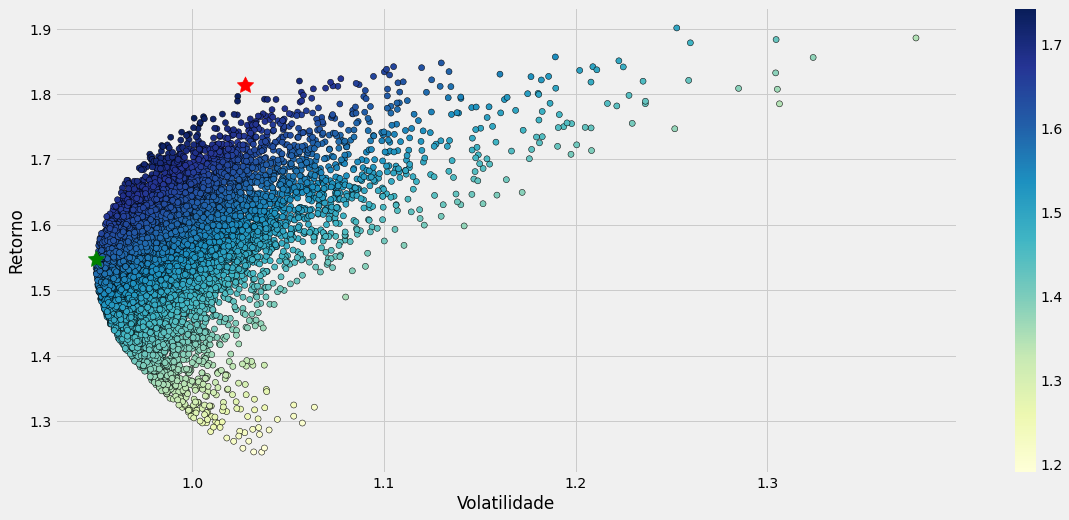

In [4]:
plt.rcParams['figure.figsize'] = (18,8)
plt.style.use('fivethirtyeight')                                                              #CMAP='PiYG, RdBu, YlGnBu, hot,RdYlGn'
plt.scatter(resultados_frame.desvio_padrao,resultados_frame.retorno,c=resultados_frame.sharpe,cmap='YlGnBu', marker='o', facecolors='none', edgecolors='black')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.colorbar()
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),label='Sharpe',color='r',s=300)
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),label='Vol Min',color='g',s=300)

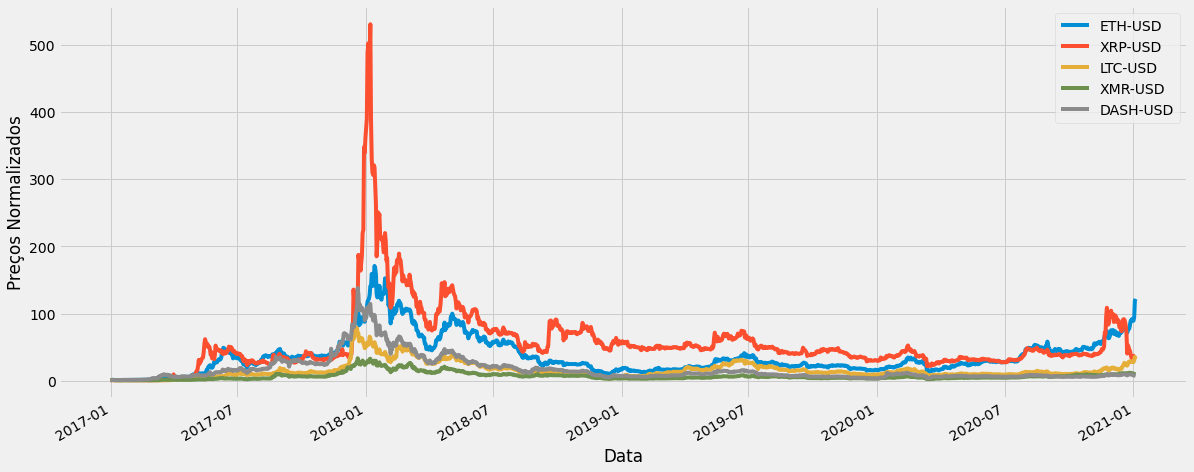

In [5]:
preços_normalizados = (preços/preços.iloc[0])
preços_normalizados.plot(figsize=(18,8))
plt.ylabel('Preços Normalizados')
plt.xlabel('Data')
plt.show()

<AxesSubplot:xlabel='None', ylabel='None'>

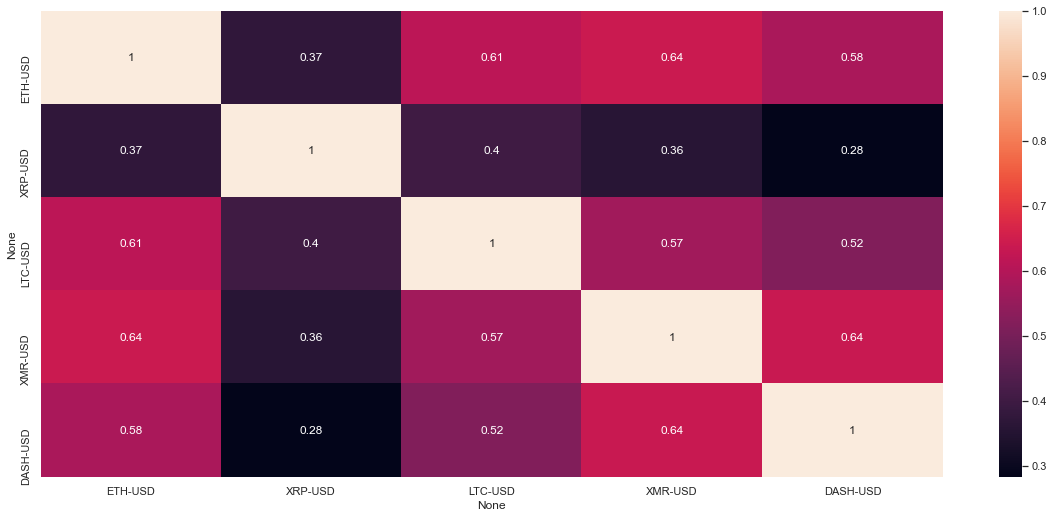

In [13]:
#Correlação entre os ativos da carteira
retornos.dropna()
retornos
retornos.columns = [criptos]
sns.set()
sns.heatmap(retornos.corr(), annot=True)

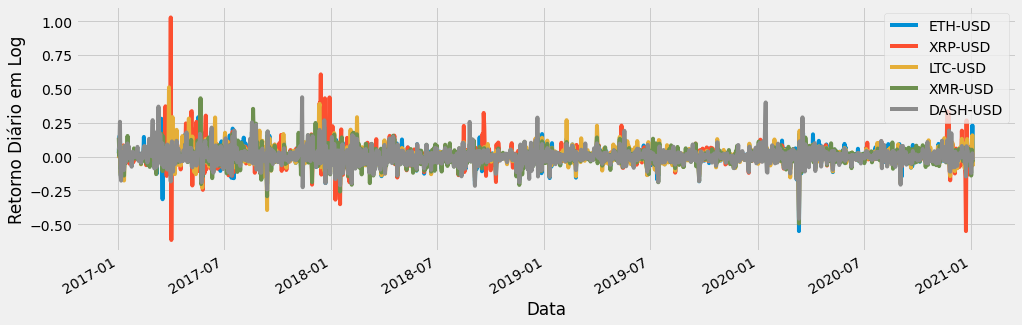

In [6]:
log_retornos=np.log(preços/preços.shift(1))
log_retornos.plot(figsize=(15,5))
plt.ylabel('Retorno Diário em Log')
plt.xlabel('Data')
plt.show()

C:\Users\LUCAS\Anaconda3\Nova pasta\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


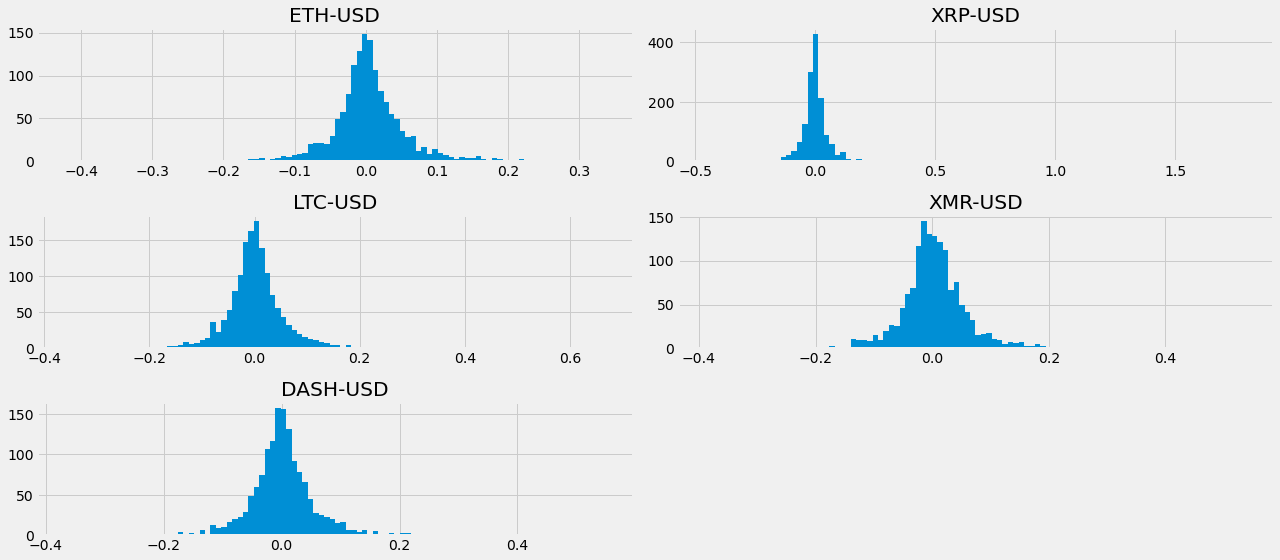

In [7]:
retornos.hist(bins=100,figsize=(18,8));
sns.distplot(retornos, kde=False)
plt.tight_layout()

In [16]:
#Composição que maximiza o Sharpe
#max_sharpe_port
max_sharpe_port*100

retorno          181.319970
desvio_padrao    102.737733
sharpe           174.488195
ETH-USD           64.989835
XRP-USD           26.340920
LTC-USD            5.348940
XMR-USD            1.048965
DASH-USD           2.271340
Name: 2353, dtype: float64

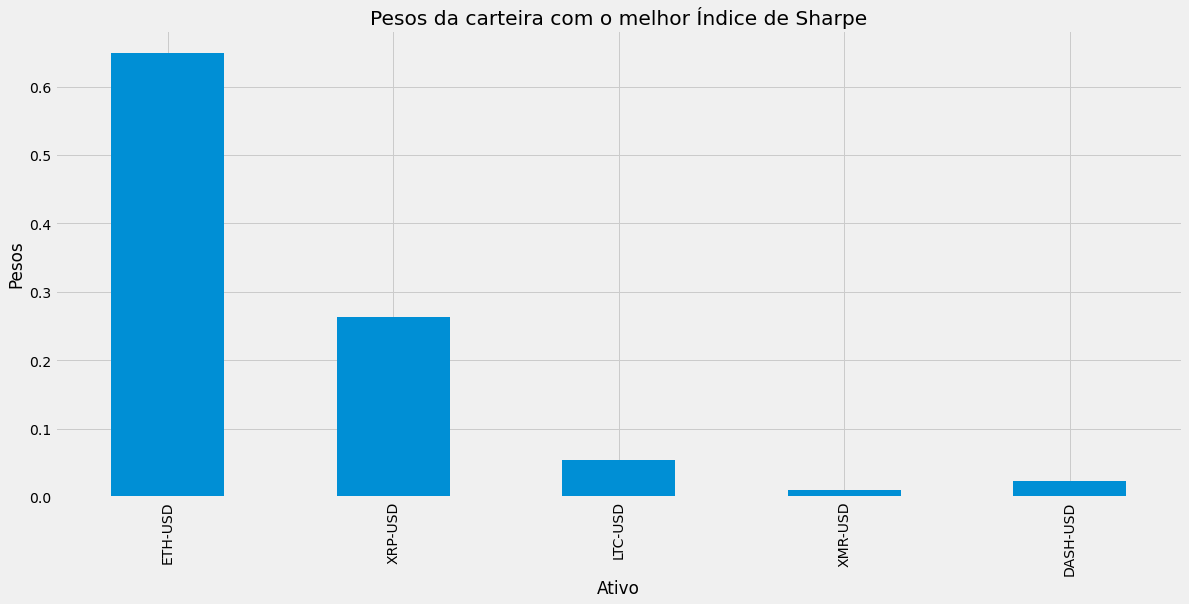

In [9]:
max_sharpe_port[criptos].plot(kind='bar')
plt.xlabel('Ativo')
plt.ylabel('Pesos')
plt.title("Pesos da carteira com o melhor Índice de Sharpe")
plt.show()

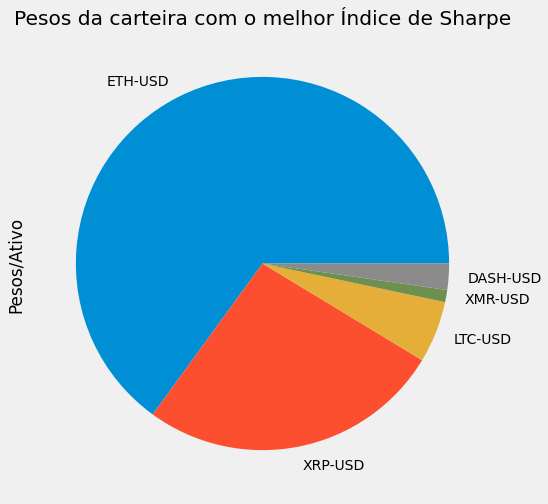

In [10]:
max_sharpe_port[criptos].plot(kind='pie')
plt.ylabel('Pesos/Ativo')
plt.title("Pesos da carteira com o melhor Índice de Sharpe")
plt.show()

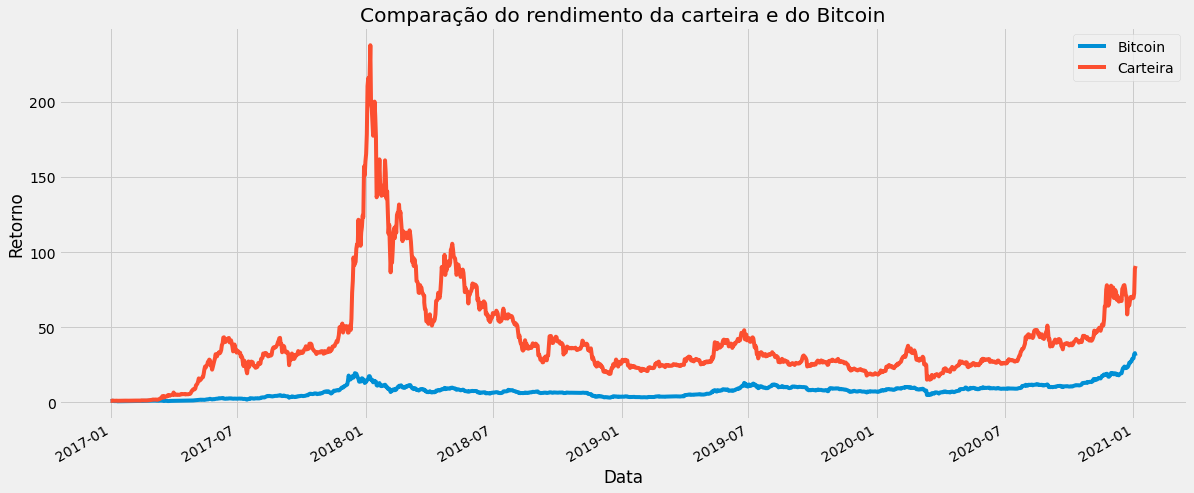

In [11]:
dados_bitcoin = pd.DataFrame()
dados_bitcoin = web.DataReader('BTC-USD', data_source='yahoo', start = data_inicio, end = data_final)['Adj Close']
bitcoin = (dados_bitcoin/dados_bitcoin.iloc[0])
retorno_carteira = 0 
for i in range(len(criptos)):
  retorno_carteira += (max_sharpe_port[criptos[i]]*preços_normalizados[criptos[i]])
bitcoin.plot(label='Bitcoin',legend='better')
retorno_carteira.plot(label='Carteira',legend='better')
plt.xlabel('Data')
plt.ylabel('Retorno')
plt.title("Comparação do rendimento da carteira e do Bitcoin")
plt.show()

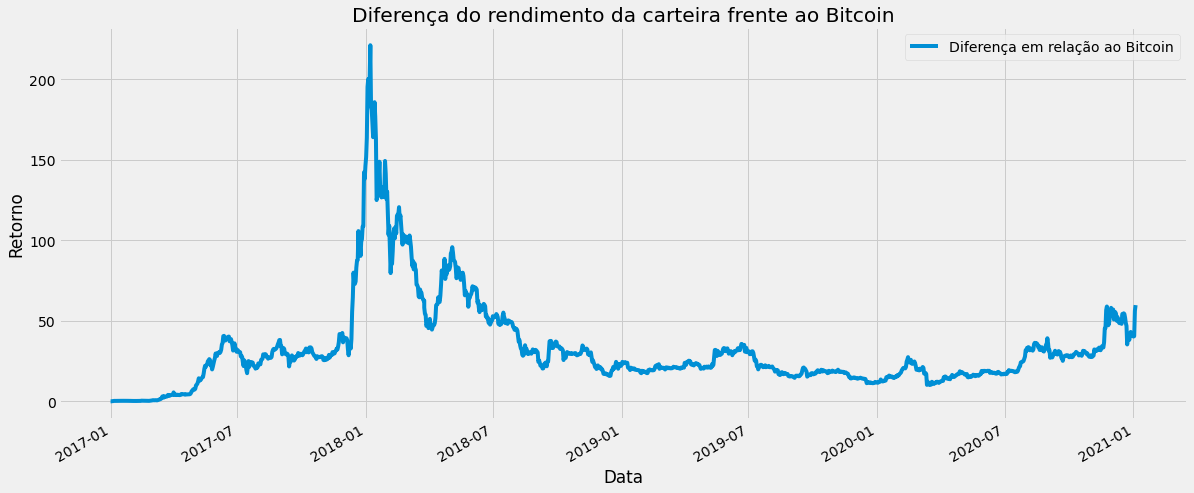

In [12]:
diferença = (retorno_carteira-bitcoin)
diferença.plot(label='Diferença em relação ao Bitcoin', legend='better')
plt.xlabel('Data')
plt.ylabel('Retorno')
plt.title("Diferença do rendimento da carteira frente ao Bitcoin")
plt.show()

### Alfa do ativo/Carteira
#### RP-RF=Alfa+Beta*(RM-RF)
Rp é o retorno da carteira, Rf é a taxa livre de risco ( no geral, a taxa de juros ), Rm é o retorno do benchmark/mercado.

O Alfa é chamado também de retorno ativo ou retorno não sistêmico – é aqui onde se mensura o quanto o benchmark/mercado foi superado.No geral é daqui de onde sai o quanto é cobrado de taxa de administração – uma carteira com alfa positivo significa que agregou valor além do benchmark, proporcionando que gestores possam beliscar uma parte desse ganho numa taxa maior. O ideal é um alfa positivo e maior.

O Beta é o chamado retorno passivo – atrelado ao benchmark/mercado, risco sistêmico ou volatilidade. De forma simplificada e direta, está atrelado no quanto ele está relacionado ao benchmark – ou o quanto os retornos do ativo está replicando a tendência do mercado. Dependendo da estratégia, um beta menor pode ser mais ou menos desejável – para um fundo passivo num momento de alta do mercado, um beta igual a 1 não significa algo ruim necessariamente, mas um beta 1 em um mercado de baixa significa que você está acompanhando essa tendência – ou seja, um beta menor seria melhor para momentos de baixa.

C:\Users\LUCAS\Anaconda3\Nova pasta\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


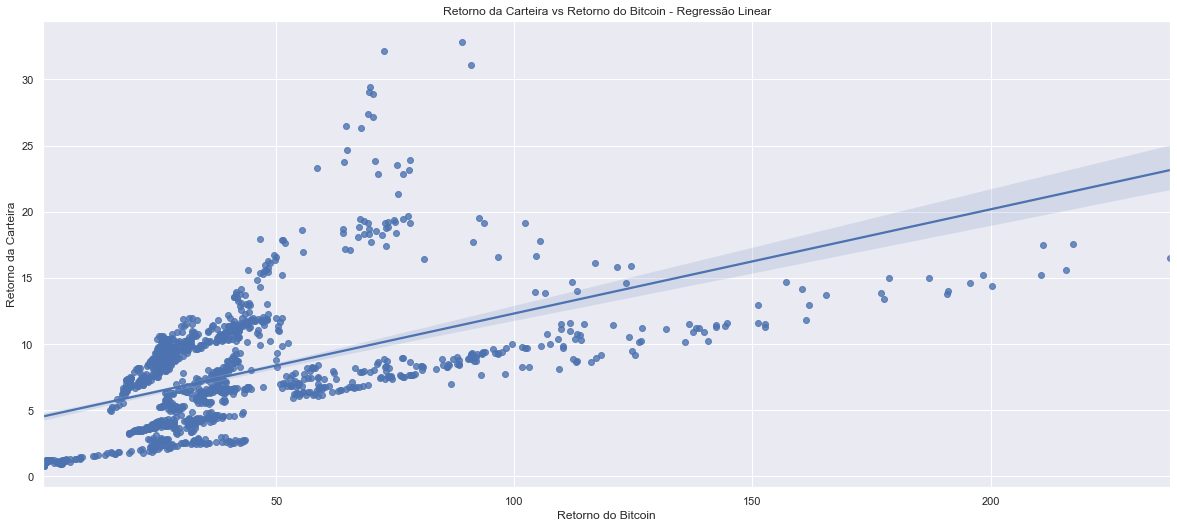

In [14]:
LR = stats.linregress(retorno_carteira.values, bitcoin.values)
sns.regplot(retorno_carteira.values, bitcoin.values)
plt.xlabel("Retorno do Bitcoin")
plt.ylabel("Retorno da Carteira")
plt.title("Retorno da Carteira vs Retorno do Bitcoin - Regressão Linear")
plt.show()

In [15]:
(beta, alfa) = LR[0:2]
print("O Beta da carteira é", beta) #Equivale ao coeficiente angular da regressão
print("O Alfa da carteira é", alfa) #Equivale ao coeficiente linear da regressão

O Beta da carteira é 0.07868269420520278
O Alfa da carteira é 4.450090802398601


# Resultados e cuidados adicionais
Com 10 mil carteiras simuladas pegando a variação dos preços de dez/2019 a dez/2020, a carteira que possui maior Índice de Sharpe (SR = 1,74, acima de 1 é bom, quanto mais próximo de 4 é excelente) foi a com pesos aproximados de 64.98% para Ethereum( ETH ),  26.34% para Ripple( XRP ), 5.34% para o Litecoin( LTC ), 1.04% para Monero( XMR ) e 2.27% para Dash( DASH ).

O Alfa atingido foi de 4.45 (essa carteira diversificada bate uma carteira com 100% de Bitcoin ) e Beta de 0,078 ( carteira menos volátil que o mercado ).

Um comentário necessário de se frisar, é que analises assim são como olhar para o retrovisor e tentar bater o mercado no futuro – no mínimo tenha cuidado, pois retornos passados não significam retornos no futuro. Ao rodar, por exemplo, esse código do artigo numa janela temporal diferente os resultados podem variar bastante.

Como sugestão, experimente benchmarks diferentes do Bitcoin, como Índice Bovespa ou Índice S&P 500, diversificar em mais classes de ativos ( ações, ETF’s, etc.), aumentar o número de ativos, a janela temporal,etc.

Fique a vontade para explorar, melhorar, otimizar essa analise para a sua realidade.

#### Referências
[1] “Markowitz e a Teoria Moderna de Portfólios”, Terraço Econômico. 

[2] “Fronteira eficiente: conheça a teoria de risco de Harry Markowitz”, Suno Research.

[3] “Portfolio Selection”, The Journal of Finance, Vol. 7, No. 1. (Mar., 1952), pp. 77-91.

[4] “Mutual Fund Performance”, The Journal of Business, Vol. 39, No. 1, Part 2: Supplement on Security Prices (Jan., 1966), pp. 119-138.